# Part1: Preprossing The Dataset


## Importing Libraries And Loading The Dataset

In [1]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime

from bs4 import BeautifulSoup

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support




In [3]:
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahmoudatiaeadatia
Your Kaggle Key: ··········


100%|██████████| 25.7M/25.7M [00:01<00:00, 19.9MB/s]


In [5]:
for dirpath, dirnames ,  filenames in os.walk("/content/data"):
    print(f"there is {len(dirnames)} dirs and {len(filenames)} files in {dirpath}")

there is 1 dirs and 0 files in /content/data
there is 0 dirs and 1 files in /content/data/imdb-dataset-of-50k-movie-reviews


In [6]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

## Exploring The Dataset

In [7]:
df_copy.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [8]:
df_copy.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


I think we have some duplicated reviews in the dataset

In [9]:
df_copy["dub"] = df_copy.duplicated()

In [10]:
df_unique = df_copy[df_copy["dub"] == False]

In [11]:
df_unique.describe()

,review,sentiment,dub
count,49582,49582,49582
unique,49582,2,1
top,One of the other reviewers has mentioned that ...,positive,False
freq,1,24884,49582


In [12]:
df_unique["sentiment"].value_counts(), df_copy["sentiment"].value_counts()

(positive    24884
 negative    24698
 Name: sentiment, dtype: int64, positive    25000
 negative    25000
 Name: sentiment, dtype: int64)

In [13]:
df_copy.groupby("sentiment").count()

,review,dub
sentiment,,
negative,25000,25000
positive,25000,25000


I will work with df_copy because it is balaneced unlike df_unique

### Visualise Some Reviews

In [14]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)



  The Review :
  Man were do I start,everything about this Cartoon from the Episodes,to the Stories,Script, an Animation is to me the Stupidest,Dummest and Most Annoying Cartoon that Walt Disney Television Animation ever CREATED and MADE ,Im so glad that Both Toon Disney (2006) and Disney Channel to Stop Airing it in the U.S. as Of This May 2008.<br /><br />Believe me it's A wise choice to skip this out cast and black cloud of A cartoon,if you watch it don't say I did not alert an warn you.<br /><br />Your in for A Boring and Down right Dull and Confusing Time,I wish and pray I never even saw 1 Episode of this Cartoon Buzz Lightyear Of Star Command. If I could I would have the Part of my Brain removed that Remembers watching it,yes it is and was that Bad.
  Seniment:
  negative
  

  The Review :
  "The sweet is never as sweet without the sour." This quote was essentially the theme for the movie in my opinion. Tom Cruise plays a young man who was handed everything in his life. He take

## Preprocessing The Texts

picking one value to test on

### Removing HTML Tags

In [15]:
value = df_copy.iloc[0]

In [16]:
value["review"]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [17]:
bs = BeautifulSoup(value["review"],"html.parser" )
value_no_html = bs.get_text()

### Removing Punctotion And Numbers

In [18]:
value_no_html

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [19]:
cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
cleaned_text

'One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty picture

Removing Stopwords

In [20]:
stopwords.words("english")[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [21]:
stopwords = stopwords.words("english")

In [22]:
[word for word in cleaned_text.split() if word not in stopwords ]

['One',
 'reviewers',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'youll',
 'hooked',
 'They',
 'right',
 'exactly',
 'happened',
 'meThe',
 'first',
 'thing',
 'struck',
 'Oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'GO',
 'Trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'This',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'Its',
 'hardcore',
 'classic',
 'use',
 'wordIt',
 'called',
 'OZ',
 'nickname',
 'given',
 'Oswald',
 'Maximum',
 'Security',
 'State',
 'Penitentary',
 'It',
 'focuses',
 'mainly',
 'Emerald',
 'City',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'Em',
 'City',
 'home',
 'manyAryans',
 'Muslims',
 'gangstas',
 'Latinos',
 'Christians',
 'Italians',
 'Irish',
 'moreso',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'awayI',
 'would',
 'say',
 'main',
 'ap

well done!
we are ready now to create our cleaning function

In [23]:
def delta_time():
  t_1 = datetime.now()
  [word for word in cleaned_text.split() if word not in stopwords ]
  t_2 = datetime.now()
  [word for word in cleaned_text.split() if word not in set(stopwords) ]
  t_3 = datetime.now()
  return t_2-t_1, t_3-t_2

delte1 , delta2 = delta_time()

In [24]:
delte1 , delta2

(datetime.timedelta(microseconds=922), datetime.timedelta(microseconds=1368))

i will use set() as a data structure to look up faster. it is not very fast for one value but it will be faster when i apply it to the whole dataset

### Cleaning Function

In [25]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text().lower()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
  text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return " ".join(text)

### Appling The clean_text Function

In [26]:
clean_text("The cat stretched. Jacob stood on his tiptoes. She opened the door.Kelly twirled in circles. ".lower())

'cat stretched jacob stood tiptoes opened doorkelly twirled circles'

It works very good

In [27]:
df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))

In [28]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)
  


  The Review :
  back august countryish buzz movies big hits like urban cowboy every way loose smokey bandit rage reason suspect producers movie chose honky tonk freeway title hoping would help movies box office receipts drawing urban cowboy crowd instead honky tonk freeway bombed theaters suspect part burdened poorly chosen title thats problem burdens video thats bad pretty good movie comedy style ahead time matter probably anybody remember enjoy itits bad movie bombed think would anyway even hadnt saddled poor title movie ahead time one could look movie see clearly father greatuncle anyway kinds comedy made today day honky tonk freeway pretty full innuendo kind frankness life didnt get popular comedy till much later clearly child airplane mature certainly knocked clearly points direction characters comedymature lowkey dont ever think anything anything serious jokes choices emphasize camera views way view situationsbut honky tonk freeway real time capsule great look back exceedingly 

### Spilt to train, validation and test

I will be running a lot of experments so i will run it just to %10 of the dataset

In [29]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   dub        50000 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


In [30]:
df_shuffeled = df_copy.sample(frac=1,random_state= 123 ) #shuffling the data

In [31]:
df_shuffeled.head()

,review,sentiment,dub
11872,movie beyond awful pimple movie industry know ...,negative,False
40828,writing john carpenters halloween nearing th a...,positive,False
36400,must admit slight disappointment film read lot...,positive,False
5166,oh dear bbc knocked pedestal absorbing period ...,negative,False
30273,totally average film semialright action sequen...,negative,False


In [32]:
df_10 = df_shuffeled[:5000]

In [33]:
df_10.head()

,review,sentiment,dub
11872,movie beyond awful pimple movie industry know ...,negative,False
40828,writing john carpenters halloween nearing th a...,positive,False
36400,must admit slight disappointment film read lot...,positive,False
5166,oh dear bbc knocked pedestal absorbing period ...,negative,False
30273,totally average film semialright action sequen...,negative,False


In [34]:
 print(len(df_10)/len(df_shuffeled))

0.1


In [35]:
x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )

In [36]:
len(x_train)

4000

In [37]:
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [38]:
len(x_train),len(x_valid),len(x_test)

(3600, 400, 1000)

# Part2: Modeling

#### Tokenization using CountVectorizer

In [39]:
cv = CountVectorizer( 
    max_features= 10000,
    lowercase= True,
)
cv_train = cv.fit_transform(x_train)
cv_test = cv.transform(x_test)
cv_valid = cv.transform(x_valid)

now we can create our first model

In [40]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(cv_train , y_train)


LogisticRegression(max_iter=1000)

In [41]:
log_reg.score(cv_train , y_train)

1.0

Evaluating the model

In [42]:
log_reg.score(cv_test,y_test)

0.851

In [43]:
# same result
(log_reg.predict(cv_test)==y_test).sum()/len(y_test)

0.851

create a function to show model results

In [44]:
def model_result( y_true,y_preds,model_name):
  acc = accuracy_score(y_true,y_preds)
  prec, recall , fscore,_ = precision_recall_fscore_support(y_true, y_preds,average="weighted")
  model = pd.DataFrame({"Accuracy":[acc],"precision": [prec], "Recall":[recall], "Fscore":fscore}, index= [model_name])
  return model

In [45]:
preds = log_reg.predict(cv_test)

In [46]:
baseline = model_result(preds,y_test, "Baseline logstic Reg")

In [47]:
baseline

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847


Not bad for our baseline model

## Model1 CountVectorizer using stemmer

---



In [48]:
#creating a stemmer class to use it in sklearn CountVectorizer
ps = PorterStemmer()
class stemmer:
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    return [ps.stem(word) for word in tokens]

In [49]:
cv1 = CountVectorizer(
    lowercase= True,
    tokenizer= stemmer(),
    max_features= 10000

)
cv1_train = cv1.fit_transform(x_train)
cv1_test = cv1.transform(x_test)
cv1_valid = cv1.transform(x_valid)

In [50]:
# running the model
model_1 = LogisticRegression(max_iter = 1000)
model_1.fit(cv1_train , y_train)

LogisticRegression(max_iter=1000)

In [51]:
preds = model_1.predict(cv1_test)

In [52]:
model_1 = model_result(y_test,preds, "Model 1 : Stemmer")

In [53]:
models = pd.concat([baseline,model_1], axis =0)
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114


## Model2 CountVectorizer using lemmetizer


In [54]:
wnl = WordNetLemmatizer()

In [55]:
def lemma_pos(pos_tag):
  if pos_tag.startswith("N"):
    return "n"
  elif pos_tag.startswith("V"):
    return "v"
  elif pos_tag.startswith("J"):
    return "r"
  elif pos_tag.startswith("R"):
    return "r"
  else: return "n"

In [56]:
class lemmatize:
  def __call__(self,doc):
    tokens = word_tokenize(doc)
    word_dict = pos_tag(tokens)
    return [wnl.lemmatize(word,lemma_pos(tag)) for word,tag in word_dict]

In [57]:
cv2 = CountVectorizer(
    max_features= 10000,
    lowercase= True,
    tokenizer= lemmatize()
)
cv2_train = cv2.fit_transform(x_train)
cv2_test = cv2.transform(x_test)
cv2_valid = cv2.transform(x_valid)

In [58]:
# running the model
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(cv2_train , y_train)

LogisticRegression(max_iter=1000)

In [59]:
model_2.score(cv2_train , y_train)

1.0

In [60]:
preds = model_2.predict(cv2_test)

In [61]:
model_2 = model_result(y_test,preds,"Model 2 : with Lemmatizer")
models = pd.concat([models,model_2], axis=0 )
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114
Model 2 : with Lemmatizer,0.852,0.853853,0.852,0.852160


## Model3 TFIDF

In [62]:
tf_idf = TfidfVectorizer(lowercase = True , max_features=10000) #term frequency–inverse document frequency
tf_train = tf_idf.fit_transform(x_train)
tf_test = tf_idf.transform(x_test)
tf_valid = tf_idf.transform(x_valid)

In [63]:
model_3 = LogisticRegression(max_iter = 1000)
model_3.fit(tf_train , y_train)

LogisticRegression(max_iter=1000)

In [64]:
model_3.score(tf_train , y_train)

0.9533333333333334

In [65]:
preds = model_3.predict(tf_test)

In [66]:
model_3 = model_result(y_test,preds,"Model 3 : with tfidf")
models = pd.concat([models,model_3], axis=0 )
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114
Model 2 : with Lemmatizer,0.852,0.853853,0.852,0.852160
Model 3 : with tfidf,0.867,0.867864,0.867,0.867119


## Model 4 : 

In [67]:
rf = RandomForestClassifier()
rf.fit(cv_train, y_train)

RandomForestClassifier()

In [68]:
rf.score(cv_train, y_train)

1.0

In [69]:
rf.score(cv_test, y_test)

0.831

In [70]:
rf1 = DecisionTreeClassifier()
rf1.fit(cv1_train, y_train)
rf1.score(cv1_train, y_train) ,rf1.score(cv1_valid, y_valid), rf1.score(cv1_test, y_test)

(1.0, 0.6575, 0.681)

In [71]:
rf2 = DecisionTreeClassifier()
rf2.fit(cv2_train, y_train)
rf2.score(cv2_train, y_train), rf2.score(cv2_test, y_test)

(1.0, 0.699)

In [72]:
rf3 = DecisionTreeClassifier()
rf3.fit(tf_train, y_train)
rf3.score(tf_train, y_train),rf3.score(tf_test, y_test)

(1.0, 0.674)

i didn't get good results for the test dataset with random forest and deecision tree



# Part3: Modeling with Deep learning 

In [73]:
! pip install opendatasets
# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime
import string

from bs4 import BeautifulSoup

od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "data/imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [74]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

In [75]:
import string
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
stopwords = stopwords.words("english")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

In [77]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text().lower()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
  text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return " ".join(text)

df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))
df_shuffeled = df_copy.sample(frac=1, random_state=123) #shuffling the data
df_10 = df_shuffeled[:5000]

x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [78]:
clean_text("hey bro , go there they the")

'hey bro go'

Preparing our data for Deep Learning

### Create tensorflow datasets

mapping - caching - shuffeling - batching - prefeching

In [79]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [80]:
le.classes_

array(['negative', 'positive'], dtype=object)

In [81]:
one_hot = OneHotEncoder(sparse = False)
y_train_onehot = one_hot.fit_transform(np.reshape(np.array(y_train),(-1,1)))
y_test_onehot = one_hot.transform(np.reshape(np.array(y_test),(-1,1)))
y_valid_onehot = one_hot.transform(np.reshape(np.array(y_valid),(-1,1)))

In [82]:
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [83]:

train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

### Creating Text Vectorizer And Embeding Layer

In [84]:
# how many word do we have in a sentence on avrage?
words_len_list = [len(sent.split()) for sent in  x_train ]
np.mean(words_len_list)

118.87777777777778

ploting words count

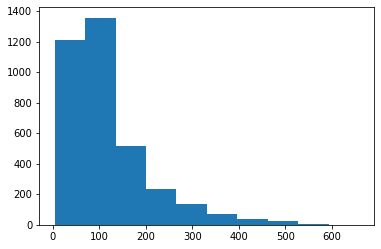

In [85]:
plt.hist(words_len_list);

In [86]:
max_words = int(np.quantile(words_len_list, q=0.95))+1 #most of the texts have less than 308words
max_words

310

In [87]:
text_vectorizer = layers.TextVectorization(max_tokens= 100000, output_sequence_length= max_words )

In [88]:
text_vectorizer.adapt(x_train)

In [89]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence Vector : {text_vectorizer([sent])}
Vector length : {len(text_vectorizer([sent])[0])}
""")


Sentence length : 93
Sentence : even year old student loves history caught glimpses emotion excitement childhood years series coming dvd blessing time north south truly series friendshiplovehonor name list feelings get watching series still remember first time caught glimpse series tv years old though wow looks exciting bad never chance see book one two tv netherlands book three broadcasted late evening series netherlands summer knew see two series people book three big disappointment far know well since seen book one dvd must say best entire books youngsters watch fancy movies like patriot oh america freedom realistic view see
Sentence Vector : [[    9   240    77  1366  1139   400   903  6484  1181  1925  1359    64
    114   429   186  8380    11  2139  1290   212   114 36398   254   887
   1159    15    63   114    45   270    20    11   903  2605   114   138
     64    77    62  1528   180   893    17    32   473     8   150     4
     34   138 12799   150   205 41747   328  1872

In [90]:
print(f"""
Number of the tokens : {len(text_vectorizer.get_vocabulary())}
Most common words : {  text_vectorizer.get_vocabulary()[:20]}
least common words {  text_vectorizer.get_vocabulary()[-20:]}
  """)


Number of the tokens : 44388
Most common words : ['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'would', 'see', 'even', 'really', 'time', 'story', 'much', 'well', 'get', 'great', 'bad', 'also', 'people']
least common words ['abbottcostello', 'abbie', 'abbas', 'abashidze', 'abandonof', 'aback', 'ab', 'aaww', 'aardmans', 'aardman', 'aamess', 'aaliyah', 'aaker', 'aaila', 'aahemy', 'aag', 'aaall', 'aaaggghhhhhhh', 'aaa', 'aa']
  


Embding Layer

In [91]:
embed = layers.Embedding(
len(text_vectorizer.get_vocabulary()),
128,
mask_zero = True #,llxdnlnl
)

In [92]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence emmbedings : {embed(text_vectorizer([sent]))}
shape : {embed(text_vectorizer([sent])).shape}
""")


Sentence length : 80
Sentence : concept excellent execution typifies overall quality abc networkapart peter jones appears rest panel consist marketing execs rather real entrepreneurswhen realised peter jones getting together simon cowell initial thoughts wow hes gonna take america balls appears abc come along destroyed concepti absolute addict dragons den uk interested see peter jones manipulated concept originated japan developed show states result neither inspiring informativeif lack drama life choice jerry springer american inventor sum struggling musician selling media mogulidea get ill produce show worthy title
Sentence emmbedings : [[[ 0.0247012   0.04213821  0.04439254 ... -0.0197916   0.03696121
    0.0223693 ]
  [ 0.03890697  0.03621428  0.03669808 ... -0.01210071  0.00969768
   -0.02152902]
  [-0.04271908 -0.03381342  0.04032843 ... -0.0253613   0.00298084
   -0.00905478]
  ...
  [ 0.02205297 -0.00047474 -0.04193611 ... -0.01484685 -0.02761408
    0.00554632]
  [ 0.02205297 

### DL Model1 : Conv1D

In [93]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5 , padding = "same", activation= "relu") (embedings)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model1 = tf.keras.models.Model(input, output)

In [94]:
dl_model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 310)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 310, 128)          5681664   
                                                                 
 conv1d (Conv1D)             (None, 310, 64)           41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65    

In [95]:
dl_model1.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [96]:
def checkpoint(model_name):
  return tf.keras.callbacks.ModelCheckpoint(("Experiments"+"/"+ model_name),save_best_only=True )

In [97]:
history1 = dl_model1.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d")])

Epoch 1/5
112/113 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6286

113/113 [==============================] - 10s 25ms/step - loss: 0.6560 - accuracy: 0.6294 - val_loss: 0.5075 - val_accuracy: 0.8700
Epoch 2/5
108/113 [===========================>..] - ETA: 0s - loss: 0.3077 - accuracy: 0.9117

113/113 [==============================] - 2s 19ms/step - loss: 0.3012 - accuracy: 0.9133 - val_loss: 0.2895 - val_accuracy: 0.9050
Epoch 3/5
112/113 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9794

113/113 [==============================] - 2s 18ms/step - loss: 0.0930 - accuracy: 0.9794 - val_loss: 0.2807 - val_accuracy: 0.8925
Epoch 4/5
113/113 [==============================] - 1s 8ms/step - loss: 0.0306 - accuracy: 0.9967 - val_loss: 0.2977 - val_accuracy: 0.8900
Epoch 5/5
113/113 [==============================] - 1s 8ms/step - loss: 0.0133 - accuracy: 0.9992 - val_loss: 0.3106 - val_accuracy: 0.8850


In [98]:
dl_model1 = tf.keras.models.load_model("/content/Experiments/conv1d")

In [99]:
dl_model1.evaluate(valid)

13/13 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.8925


[0.28065112233161926, 0.8924999833106995]

In [100]:
preds = dl_model1.predict(test)

32/32 [==============================] - 0s 3ms/step


In [101]:
print(confusion_matrix(y_test, np.round(preds)))

[[416  65]
 [ 60 459]]


In [102]:
print( f"Acuracy : {(432+424) / len(y_test)}" )

Acuracy : 0.856


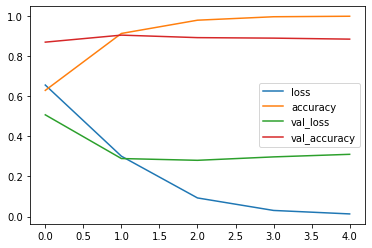

In [103]:
pd.DataFrame(history1.history).plot()

In [104]:
dl_1 = model_result(y_test, np.round(preds),"DL Model 1 : Conv1D")
models = pd.concat([models, dl_1],axis=0)
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114
Model 2 : with Lemmatizer,0.852,0.853853,0.852,0.852160
Model 3 : with tfidf,0.867,0.867864,0.867,0.867119
DL Model 1 : Conv1D,0.875,0.874990,0.875,0.874973


## DL Model2 : with pretrained word embedings

In [105]:
use_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable= False) #

In [106]:
input = layers.Input([], dtype= tf.string) # an empty list following the documentation
embedings = use_embed_layer(input )
x = layers.Dense(128, activation="relu") (embedings)
x = layers.Dense(64, activation="relu") (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model2 = tf.keras.models.Model(input, output)

In [107]:
dl_model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [108]:
dl_model2.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [121]:
history2 = dl_model2.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("use_embedings")])

Epoch 1/5
113/113 [==============================] - 12s 107ms/step - loss: 0.3730 - accuracy: 0.8353 - val_loss: 0.3510 - val_accuracy: 0.8600
Epoch 2/5
113/113 [==============================] - 12s 107ms/step - loss: 0.3678 - accuracy: 0.8383 - val_loss: 0.3505 - val_accuracy: 0.8575
Epoch 3/5
113/113 [==============================] - 4s 36ms/step - loss: 0.3635 - accuracy: 0.8372 - val_loss: 0.3506 - val_accuracy: 0.8500
Epoch 4/5
113/113 [==============================] - 3s 26ms/step - loss: 0.3594 - accuracy: 0.8392 - val_loss: 0.3508 - val_accuracy: 0.8525
Epoch 5/5
113/113 [==============================] - 3s 26ms/step - loss: 0.3555 - accuracy: 0.8414 - val_loss: 0.3510 - val_accuracy: 0.8475


In [110]:
dl_model2.evaluate(test)

32/32 [==============================] - 1s 23ms/step - loss: 0.3779 - accuracy: 0.8230


[0.3779093325138092, 0.8230000138282776]

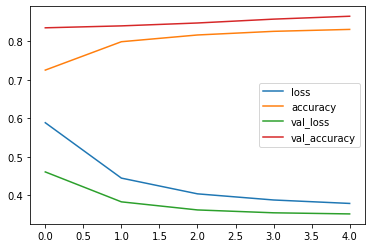

In [120]:
pd.DataFrame(history2.history).plot()

In [111]:
preds = dl_model2.predict(test)

32/32 [==============================] - 1s 22ms/step


In [112]:
dl_2 = model_result(y_test, np.round(preds),"DL Model 1 : use emmeding")
models = pd.concat([models, dl_2],axis=0)
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114
Model 2 : with Lemmatizer,0.852,0.853853,0.852,0.852160
Model 3 : with tfidf,0.867,0.867864,0.867,0.867119
DL Model 1 : Conv1D,0.875,0.874990,0.875,0.874973
DL Model 1 : use emmeding,0.823,0.823145,0.823,0.822834


DL Model3: GRU 

In [113]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.LSTM(520) (embedings)
x= layers.Dropout(0.2) (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model3 = tf.keras.models.Model(input, output)

In [114]:
dl_model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 310)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 310, 128)          5681664   
                                                                 
 lstm (LSTM)                 (None, 520)               1349920   
                                                                 
 dropout (Dropout)           (None, 520)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 521       
                                                           

In [115]:
dl_model3.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [116]:
history3 = dl_model3.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("LSTM")])

Epoch 1/5
112/113 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.7896

113/113 [==============================] - 22s 152ms/step - loss: 0.5267 - accuracy: 0.7900 - val_loss: 0.5641 - val_accuracy: 0.7200
Epoch 2/5
113/113 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9539

113/113 [==============================] - 30s 264ms/step - loss: 0.1411 - accuracy: 0.9539 - val_loss: 0.5566 - val_accuracy: 0.8350
Epoch 3/5
113/113 [==============================] - 6s 55ms/step - loss: 0.0309 - accuracy: 0.9908 - val_loss: 0.6548 - val_accuracy: 0.8400
Epoch 4/5
113/113 [==============================] - 7s 57ms/step - loss: 0.0085 - accuracy: 0.9989 - val_loss: 0.8020 - val_accuracy: 0.8325
Epoch 5/5
113/113 [==============================] - 7s 65ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.7924 - val_accuracy: 0.8375


In [117]:
preds = dl_model3.predict(test)

32/32 [==============================] - 4s 31ms/step


In [118]:
dl_3 = model_result(y_test, np.round(preds),"DL Model 3 : LSTM ")
models = pd.concat([models, dl_3],axis=0)
models

,Accuracy,precision,Recall,Fscore
Baseline logstic Reg,0.851,0.851762,0.851,0.850847
Model 1 : Stemmer,0.844,0.844559,0.844,0.844114
Model 2 : with Lemmatizer,0.852,0.853853,0.852,0.852160
Model 3 : with tfidf,0.867,0.867864,0.867,0.867119
DL Model 1 : Conv1D,0.875,0.874990,0.875,0.874973
DL Model 1 : use emmeding,0.823,0.823145,0.823,0.822834
DL Model 1 : use emmeding,0.838,0.844377,0.838,0.837730


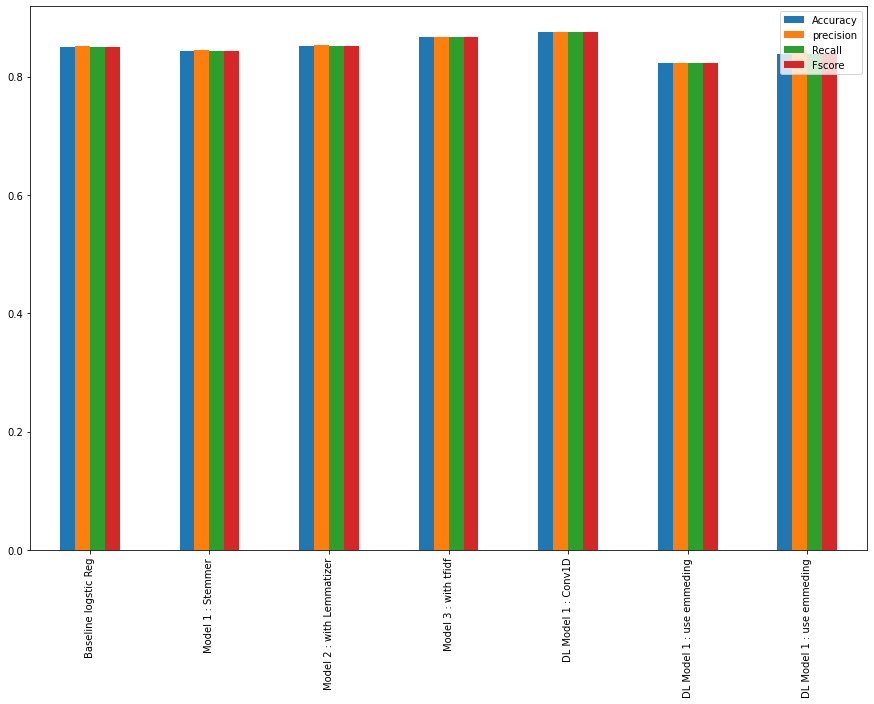

In [127]:
models.plot(kind="bar", figsize =(15,10))

### Picking a Model

In [226]:
x_train , x_test , y_train , y_test = train_test_split(df_copy["review"],df_copy["sentiment"], test_size=0.2 , shuffle= True )
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [227]:
labels = y_test

In [228]:
labels

25968    negative
21196    positive
3338     negative
24089    positive
15480    negative
           ...   
20316    positive
36175    positive
34521    negative
12321    negative
7763     positive
Name: sentiment, Length: 10000, dtype: object

In [230]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [231]:
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

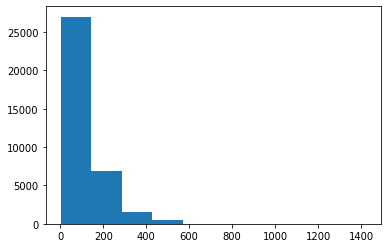

In [232]:
words_len_list = [len(sent.split()) for sent in  x_train ]
np.mean(words_len_list)
plt.hist(words_len_list);

In [233]:
max_words = int(np.quantile(words_len_list, q=0.95))+1 #most of the texts have less than 307 words
max_words

307

In [234]:
text_vectorizer = layers.TextVectorization(max_tokens= 60000, output_sequence_length= max_words )
text_vectorizer.adapt(x_train)

I wanted to include many words as possible but there are too much spelling mistakes

In [235]:
print(f"""
Number of the tokens : {len(text_vectorizer.get_vocabulary())}
Most common words : {  text_vectorizer.get_vocabulary()[:20]}
least common words {  text_vectorizer.get_vocabulary()[-20:]}
  """)


Number of the tokens : 60000
Most common words : ['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'even', 'would', 'time', 'really', 'see', 'story', 'much', 'well', 'get', 'great', 'people', 'also', 'bad']
least common words ['lassander’s', 'lasek', 'lasciviousness', 'larva', 'larters', 'larsen', 'larissa', 'larges', 'largelyforgotten', 'laredo', 'larded', 'larch', 'larcenous', 'laras', 'lar', 'laps', 'lappland', 'lapped', 'lapdog', 'laotian']
  


In [236]:
embed = layers.Embedding(
len(text_vectorizer.get_vocabulary()),
128,
mask_zero = True 
)

In [237]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.Conv1D(filters = 512, kernel_size = 5 , padding = "same", activation= "relu") (embedings)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model1_all = tf.keras.models.Model(input, output)

In [238]:
dl_model1_all.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 307)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 307, 128)          7680000   
                                                                 
 conv1d_21 (Conv1D)          (None, 307, 512)          328192    
                                                                 
 global_average_pooling1d_3   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 513

In [239]:
dl_model1_all.compile(
    loss = "binary_crossentropy",
    optimizer= tf.keras.optimizers.Adam(0.00001),
    metrics = "accuracy"
)

In [259]:
history1_all = dl_model1_all.fit(train, 
                     epochs =10,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d_all")])

Epoch 1/10
1122/1125 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9518

1125/1125 [==============================] - 20s 18ms/step - loss: 0.1458 - accuracy: 0.9519 - val_loss: 0.2702 - val_accuracy: 0.8963
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9536

1125/1125 [==============================] - 19s 17ms/step - loss: 0.1412 - accuracy: 0.9536 - val_loss: 0.2699 - val_accuracy: 0.8972
Epoch 3/10
1124/1125 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9557

1125/1125 [==============================] - 17s 15ms/step - loss: 0.1368 - accuracy: 0.9557 - val_loss: 0.2698 - val_accuracy: 0.8970
Epoch 4/10
1125/1125 [==============================] - 16s 14ms/step - loss: 0.1325 - accuracy: 0.9573 - val_loss: 0.2698 - val_accuracy: 0.8985
Epoch 5/10
1125/1125 [==============================] - 17s 15ms/step - loss: 0.1283 - accuracy: 0.9589 - val_loss: 0.2699 - val_accuracy: 0.8978
Epoch 6/10
1125/1125 [==============================] - 16s 15ms/step - loss: 0.1242 - accuracy: 0.9603 - val_loss: 0.2702 - val_accuracy: 0.8972
Epoch 7/10
1125/1125 [==============================] - 18s 16ms/step - loss: 0.1203 - accuracy: 0.9618 - val_loss: 0.2705 - val_accuracy: 0.8978
Epoch 8/10
1125/1125 [==============================] - 16s 14ms/step - loss: 0.1165 - accuracy: 0.9634 - val_loss: 0.2710 - val_accuracy: 0.8970
Epoch 9/10
1125/1125 [==============================] - 16s 14ms/step - loss: 0.1128 - accuracy: 0.9647 - val_loss: 0.2716 - val_accura

I tweaked the learing rate and trained the model for more epochs

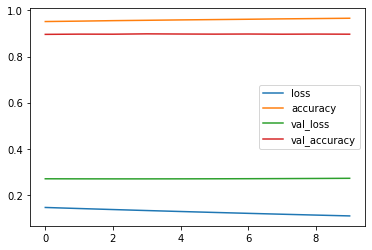

In [261]:
pd.DataFrame(history1_all.history).plot()

In [241]:
0.8913

0.8913

In [262]:
dl_model1_all.save("/content/drive/MyDrive/Kaggle projects/all_conv1D" )

In [263]:
dl_model1_all = tf.keras.models.load_model("/content/Experiments/conv1d_all")

In [264]:
dl_model1_all.evaluate(test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2799 - accuracy: 0.8938


[0.27992820739746094, 0.8938000202178955]

In [265]:
preds =(dl_model1_all.predict(test))

313/313 [==============================] - 1s 4ms/step


we have our best model so far

In [266]:
dl_all = model_result(y_test, np.round(preds),"DL Model All ")
dl_all

,Accuracy,precision,Recall,Fscore
DL Model All,0.8938,0.89397,0.8938,0.893792


In [267]:
df = pd.DataFrame({"Reviews":( x_test),"Probs":(np.round(tf.squeeze((preds)),6) ),"Y_preds": tf.squeeze(np.round(preds)), "Y_true": y_test, "Labels":labels})

In [268]:
most_wrong_values = df[df["Y_preds"]!=df["Y_true"]].sort_values(by="Probs" ,ascending=False)

In [270]:
most_wrong_values.head(20) # negatives but predicted as positive 

,Reviews,Probs,Y_preds,Y_true,Labels
44412,franco zeffirellis taming shrew romeo juliet j...,0.999919,1.0,0,negative
36289,voor een verloren soldaat lost soldier sad exa...,0.999859,1.0,0,negative
5344,one time greatest horror movies charles band m...,0.999831,1.0,0,negative
35606,duke film based heart british aristocracy old ...,0.999820,1.0,0,negative
13075,realize living western plains wyoming brutal f...,0.999756,1.0,0,negative
38389,saw film sneak preview venice opening tellurid...,0.999200,1.0,0,negative
49819,many fans little show know know words gonna fi...,0.999049,1.0,0,negative
49768,ken harrison young sculptor early thirties ser...,0.998965,1.0,0,negative
39286,happy days one favorite shows aired critics qu...,0.998222,1.0,0,negative
26910,saw chan missing first came four years moving ...,0.997795,1.0,0,negative


In [271]:
most_wrong_values.tail(20) 

,Reviews,Probs,Y_preds,Y_true,Labels
20282,must say thought seen extremely jaded movie bu...,0.004186,0.0,1,positive
22252,film mind weakest film original star wars tril...,0.003988,0.0,1,positive
7616,dw griffith could made film wanted enormous fi...,0.003719,0.0,1,positive
37557,im sick tired people complaining never say nev...,0.003512,0.0,1,positive
39564,sasquatch hunters actually wasnt bad thoughtsp...,0.003114,0.0,1,positive
1513,allbutignored masterpiece monkees becoming awa...,0.002565,0.0,1,positive
31901,talk blast opening trampa infernal coolest ope...,0.002556,0.0,1,positive
3283,unlike commenters staging class war dont mind ...,0.002148,0.0,1,positive
39341,lossessa also known tormented sexorcist ridicu...,0.001643,0.0,1,positive
35533,think cheesiest guilty pleasuretype movies fir...,0.001387,0.0,1,positive


In [272]:
for i in range(5):
  print (f"""
  Reveiw : {most_wrong_values["Reviews"].iloc[i]}
  true label : {most_wrong_values["Y_true"].iloc[i]}
  predicted : {most_wrong_values["Y_preds"].iloc[i]}
  probabilty : {most_wrong_values["Probs"].iloc[i]}
  label : {most_wrong_values["Labels"].iloc[i]}


  """)


  Reveiw : franco zeffirellis taming shrew romeo juliet jesus nazareth othello third stab transferring shakespeare screen works well casting mel gibson mad max lethal weapon prethe passion christ notoriety role formerly owned sir laurence olivier rightly see review hamlet arguably best interpretation one bards timeless quoted tragedies redone years later kenneth branagh fullbloodied treatment explaining hour minute running time combined dream cast lot little additions wellchosen expertly done contemporary master william shakespeare kenneth branagh director henry v dead joining lethal weapon star glenn close big chill paul scofield man seasons alan bates ian holm michael maloney would cast roderigo opposite kenneth branagh laurence fishburne oliver parkers othello see review oliviers stage version tragedy though starred branagh would cast laertes hour version hamlet proper homage sir laurence olivier classic version play see review one well years later nathaniel parker would cast cassi

In [274]:
for i in range(5):
  print (f"""
  Reveiw : {most_wrong_values["Reviews"].iloc[-i]}
  true label : {most_wrong_values["Y_true"].iloc[-i]}
  predicted : {most_wrong_values["Y_preds"].iloc[-i]}
  probabilty : {most_wrong_values["Probs"].iloc[-i]}
  label : {most_wrong_values["Labels"].iloc[-i]}


  """)


  Reveiw : franco zeffirellis taming shrew romeo juliet jesus nazareth othello third stab transferring shakespeare screen works well casting mel gibson mad max lethal weapon prethe passion christ notoriety role formerly owned sir laurence olivier rightly see review hamlet arguably best interpretation one bards timeless quoted tragedies redone years later kenneth branagh fullbloodied treatment explaining hour minute running time combined dream cast lot little additions wellchosen expertly done contemporary master william shakespeare kenneth branagh director henry v dead joining lethal weapon star glenn close big chill paul scofield man seasons alan bates ian holm michael maloney would cast roderigo opposite kenneth branagh laurence fishburne oliver parkers othello see review oliviers stage version tragedy though starred branagh would cast laertes hour version hamlet proper homage sir laurence olivier classic version play see review one well years later nathaniel parker would cast cassi

I think we need to improve our data. I couldn't myself consider some of the reviews as positive or negative. I think we must have a neutral label also. The highest accuracy I had after training different models was 0.8979.